# Importing Libraries

In [11]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
import numpy as np
import os, io
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise.model_selection import KFold
from surprise.model_selection.split import train_test_split
from surprise import accuracy
from surprise.accuracy import rmse
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading the input data

In [12]:
# Reading csv file to data_df.

reader = Reader(rating_scale=(0, 10))

data_df = pd.read_csv('RS_train.csv',sep=',')
data = Dataset.load_from_df(data_df[['User_Id', 'Book_Id', 'Rating']], reader)

In [13]:
data

In [14]:
data_df.head()

,User_Id,Book_Id,Rating
0,114,101170,8
1,169,93424,7
2,183,266719,7
3,183,331686,7
4,183,368596,7


In [15]:
# Description of test dataset
data_df.describe()

,User_Id,Book_Id,Rating
count,333627.000000,333627.000000,333627.000000
mean,128872.771125,142880.350922,7.603539
std,76721.827445,97583.074125,1.842235
min,8.000000,3.000000,1.000000
25%,62667.000000,67676.000000,7.000000
50%,126492.000000,121750.000000,8.000000
75%,194600.000000,210817.500000,9.000000
max,264321.000000,370356.000000,10.000000


In [16]:
# Checking for null values in train dataset
data_df.isnull().sum()

User_Id    0
Book_Id    0
Rating     0
dtype: int64

In [17]:
data_dt = pd.read_csv('RS_test.csv',sep=',')

In [18]:
data_dt.head()

,User_Id,Book_Id
0,242,343676
1,254,58191
2,503,76983
3,626,340144
4,628,261446


In [19]:
data_dt.describe()

,User_Id,Book_Id
count,100000.000000,100000.000000
mean,157427.061280,142888.857770
std,89216.344361,97724.600089
min,8.000000,1.000000
25%,80067.000000,67692.000000
50%,161041.000000,121683.000000
75%,246823.000000,210388.250000
max,278854.000000,370323.000000


In [20]:
# Checking for null values in test dataset
data_dt.isnull().sum()

User_Id    0
Book_Id    0
dtype: int64

# Distribution Of Rating

In [21]:
data_rating = data_df.Rating.value_counts(sort=False)
data_rating

1      1374
2      2065
3      4606
4      6780
5     39271
6     28234
7     58880
8     79923
9     51939
10    60555
Name: Rating, dtype: int64

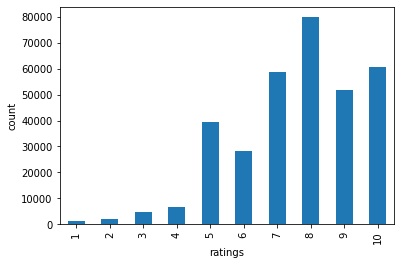

In [22]:
# Plotting the Count of Ratings
data_rating.plot(kind='bar')
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

The most rated book is [Book_Id : 38732] and it has received 565 ratings.

In [23]:
book_ratings = pd.DataFrame(data_df.groupby('Book_Id')['Rating'].count())
book_ratings.sort_values('Rating', ascending=False)

,Rating
Book_Id,
38732,565
216754,427
71062,356
32500,262
21426,258
...,...
140343,1
140331,1
140326,1


User with id 11676 gave highest number of 6845 ratings.

In [24]:
user_ratings = pd.DataFrame(data_df.groupby('User_Id')['Rating'].count())
user_ratings.sort_values('Rating', ascending=False)

,Rating
User_Id,
11676,6845
98391,4700
153662,1610
189835,1556
23902,1134
...,...
134442,1
134453,1
134460,1


In [25]:
#Check dimensions of the dataframe
data_df.shape

(333627, 3)

In [26]:
#Get a quick view of the counts for each rating value
data_df.Rating.value_counts()

8     79923
10    60555
7     58880
9     51939
5     39271
6     28234
4      6780
3      4606
2      2065
1      1374
Name: Rating, dtype: int64

In [27]:
#Drop duplicate rows in place
data_df.drop_duplicates(subset=['User_Id', 'Book_Id', 'Rating'], keep=False, inplace=True)

In [28]:
#Check the dimensions again
data_df.shape

(333627, 3)

noticed that there are no duplicate row

# Training Model:(Matrix Factorization)

After implementing multiple models BaselineOnly() is giving better RMSE score than other Models.

From scikit-surprise chosen Matrix Factorization based BaselineOnly algorithm to predict the ratings for given user and book id.

Implemented BaselineOnly algorithm with following parameters:
Number of iterations(n_epochs) = 5
The regularization parameter for items(reg_i) = 5
The regularization parameter for users(reg_u) = 12
method to use(method) = als

Used Kfold cross validation with size of splits equall to 3


https://surprise.readthedocs.io/en/stable/matrix_factorization.html


https://surprise.readthedocs.io/en/stable/getting_started.html#use-cross-validation-iterators


https://surprise.readthedocs.io/en/stable/prediction_algorithms.html

In [29]:
from surprise import BaselineOnly
print('Using ALS')
bsl_options = {'method': 'als',
 'n_epochs': 5,
 'reg_u': 12,
 'reg_i': 5,         
 }

algo = BaselineOnly(bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([1.66154318, 1.6568621 , 1.65766215]),
 'fit_time': (1.0302848815917969, 1.2520620822906494, 1.4402451515197754),
 'test_time': (1.402514934539795, 1.1203360557556152, 1.2692410945892334)}

In [30]:
algo.fit(data.build_full_trainset()) #Build the model using entire training dataset

Estimating biases using als...


Creating column1(col1) 'user_id-book_id' by Joining both user_id and book_id with'-'

In [31]:
col1=[]
for i in range(len(data_dt)):
    col1.append("{}-{}".format(data_dt.loc[i, "User_Id"], data_dt.loc[i, "Book_Id"]))

Column2(col2) Predicting ratings for given user id and book id take est value and 
adding them to ratings list.

https://surprise.readthedocs.io/en/stable/getting_started.html#train-on-a-whole-trainset-and-the-predict-method

In [32]:
col2=[]
for _, row in data_dt.iterrows():
    col2.append(algo.predict(row['User_Id'], row['Book_Id']).est)

For Generating csv file,Creating a dictionary and converting to dataframe using pandas library.

In [33]:
d={'User_Id-Book_Id':col1, 'Rating': col2}
Predicted_Ratings=pd.DataFrame(d)
Predicted_Ratings

,User_Id-Book_Id,Rating
0,242-343676,8.178479
1,254-58191,7.433056
2,503-76983,8.124847
3,626-340144,7.864436
4,628-261446,7.298269
...,...,...
99995,278652-67198,7.027702
99996,278668-357564,7.493002
99997,278672-321252,7.355132
99998,278820-77841,7.152533


Converting Predicted_Ratings to csv file 'Book_RatingPrediction.csv'

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html

In [34]:
csv_name = "RS_sample.csv"
Predicted_Ratings.to_csv(csv_name, index=False)

# All the other models that I tried(For reference only):

In [20]:
algo1=SVD(n_epochs=50,n_factors =100)
kf = KFold(n_splits=5)
trainingSet = data.build_full_trainset()
for trainset, testset in kf.split(data):
    algo1.fit(trainset)
    predictions = algo1.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.6523
RMSE: 1.6527
RMSE: 1.6562
RMSE: 1.6417
RMSE: 1.6584


In [27]:
algo2=SVD(n_factors=132, n_epochs=50, lr_all=0.01, reg_all=0.2, random_state=42, verbose=True)

kf = KFold(n_splits=5)
trainingSet = data.build_full_trainset()
for trainset, testset in kf.split(data):
    algo2.fit(trainset)
    predictions = algo2.test(testset)
    accuracy.rmse(predictions, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 1.65

In [19]:
algo3=SVD(n_factors=200, n_epochs=105, lr_all=0.01, reg_all=0.1, random_state=42, verbose=True)

kf = KFold(n_splits=5)
trainingSet = data.build_full_trainset()
for trainset, testset in kf.split(data):
    algo3.fit(trainset)
    predictions = algo3.test(testset)
    accuracy.rmse(predictions, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [25]:
#Define the algorithm with final tuned parameters
algo4=SVD(n_factors=132, n_epochs=50, lr_all=0.01, reg_all=0.2, random_state=42, verbose=True)

#Run 5-fold cross-validation and print results
cross_validate(algo4, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

{'test_rmse': array([1.65186795, 1.65722049, 1.65630297]),
 'test_mae': array([1.29012937, 1.29157913, 1.29286457]),
 'fit_time': (61.35222601890564, 63.277019023895264, 65.82569694519043),
 'test_time': (1.7548291683197021, 1.816129207611084, 1.7679791450500488)}

In [11]:
from surprise import KNNBasic
from surprise import Dataset                                                     
from surprise import Reader                                                      
from surprise.model_selection import PredefinedKFold
from surprise import dump
from surprise.accuracy import rmse



# We'll use a basic nearest neighbor approach, where similarities are computed
# between users.
kf = KFold(n_splits=3)
algo5 = KNNBasic(n_factors=132, n_epochs=50, lr_all=0.01, reg_all=0.2, random_state=42, verbose=True)                                                       

for trainset, testset in kf.split(data):
    algo5.fit(trainset)                             
    predictions = algo5.test(testset)
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.9225
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.9199
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.9244


In [12]:
from surprise import KNNBaseline

algo6 = KNNBaseline()
kf = KFold(n_splits=2)

for trainset, testset in kf.split(data):
    algo6.fit(trainset)                             
    predictions = algo6.test(testset)
    accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7361
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7392


In [36]:
print('Using SGD')
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }
algo_sgd = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo_sgd, data, measures=['RMSE'], cv=3, verbose=False)

Using SGD
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


{'test_rmse': array([1.80289142, 1.80219677, 1.80243346]),
 'fit_time': (2.419487953186035, 2.5072619915008545, 2.499282121658325),
 'test_time': (0.9609780311584473, 0.6951847076416016, 1.3907477855682373)}

In [ ]:
from surprise import KNNBasic

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo8 = KNNBasic(sim_options=sim_options)

kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    algo8.fit(trainset)                             
    predictions = algo8.test(testset)
    accuracy.rmse(predictions, verbose=True)

Computing the cosine similarity matrix...


In [ ]:
from surprise import KNNBasic
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

In [48]:
#algo1.fit(data.build_full_trainset()) #Build the model using entire training dataset 
#algo2.fit(data.build_full_trainset()) #Build the model using entire training dataset 
#algo3.fit(data.build_full_trainset()) #Build the model using entire training dataset 
#algo4.fit(data.build_full_trainset()) #Build the model using entire training dataset 
#algo5.fit(data.build_full_trainset()) #Build the model using entire training dataset 
#algo6.fit(data.build_full_trainset()) #Build the model using entire training dataset 

Estimating biases using als...
